### **Unzip the dataset,downloaded from kaggle on google colab**

In [ ]:
!unzip archive.zip

### **Create the image folders for the corresponding classes**

In [ ]:
import cv2
import glob
import os

#import torch
#Path of dataset and new dataset,change these two variables if needed 
path="/content/fingers"
new_path = "/content/Assignment3"

subDirectories = os.listdir(path) 

#Image Dataset holder
images = []
imageList= []

#from csv import writer
 

hands=['L','R'] 
labels1=[]
labels2={}

for hand in hands:
    for i in range(0,6):
        labels1.append(str(i)+hand) 
        labels2[str(i)+hand]=str(i)+hand

counterImagesProcessed=0
if os.path.exists(new_path)==False:
    os.mkdir(new_path)
    for folder in subDirectories:
      os.mkdir(new_path+"/"+folder)
      for category in labels2:
        os.mkdir(new_path+"/"+folder+"/"+category)
    #newSubDirectories = os.listdir(new_path) 
    for folder in subDirectories:
        currentPath=path+"/" +folder
        images = os.listdir(currentPath)
        for image in images:
            newCurrentPath=new_path+"/"+folder+"/"+image[-6]+image[-5]+"/"+image
            cv2.imwrite(newCurrentPath,cv2.imread(currentPath+"/"+image))
            counterImagesProcessed=counterImagesProcessed+1

else:
    print("Dataset Alreay Exists")

### **Import Libraries**

In [ ]:
from math import ceil
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import matplotlib.pyplot as plt
import time
from torchvision import models

### **Set device to GPU or CPU. Also set dataset label map**

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
labels_map = {
      0: "0-Left",
      1: "0-Right",
      2: "1-Left ",
      3: "1-Right ",
      4: "2-Left ",
      5: "2-Right ",
      6: "3-Left ",
      7: "3-Right ",
      8: "4-Left ",
      9: "4-Right",
      10: "5-Left ",
      11: "5-Right ",
}

### **Data Loader**

In [ ]:
def data_loader(data_dir_input,batch_sizeGiven,input_size,test_split,val_split,flag=0):
# Define dataset directory and transforms
  data_dir = data_dir_input #
  test_transform=train_transform = transforms.Compose([
      transforms.Resize(input_size, interpolation=transforms.InterpolationMode.BILINEAR),
      transforms.RandomRotation(50),
      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
      transforms.RandomPerspective(distortion_scale=0.2, p=0.2),
      transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
      transforms.ToTensor(),           
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])


# Define train, validation, and test dataset
  train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train/'), transform=train_transform)
  data_directory_test = data_dir+"/"+"test"+"/"
  test_dataset = datasets.ImageFolder(data_directory_test, transform=test_transform)
  train_loader = DataLoader(train_dataset, batch_size=batch_sizeGiven, shuffle=True, drop_last=False, num_workers=0,pin_memory=True)
  val_size = int(ceil((len(test_dataset)*val_split) / (test_split+val_split)))
  test_size = len(test_dataset) - val_size
  test_dataset, val_dataset = td.random_split(test_dataset, [test_size, val_size])


  test_loader = DataLoader(test_dataset, batch_size=batch_sizeGiven, shuffle=True, drop_last=False, num_workers=0,pin_memory=True) #shuffle 
  val_loader = DataLoader(val_dataset, batch_size=batch_sizeGiven, shuffle=True, drop_last=False, num_workers=0,pin_memory=True) # shuffle working
  if flag==1:
    print("Train Datset Size Before Split",len(train_dataset))
    print("Test Datset Size Before Split",len(test_dataset))
    print("################################################")
    print("Train Datset Size After Split",len(train_dataset))
    print("Test Datset Size After Split",len(test_dataset))
    print("Validation Datset Size After Split",len(val_dataset))

    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
      sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
      img, label = train_dataset[sample_idx]
      img=img.view(128,128,3)
      figure.add_subplot(rows, cols, i)
      plt.title(labels_map[label])
      plt.axis("off")
      plt.imshow(img.squeeze())
    print("\n\n\n################################################\n\n\n")
    print("Dataset After Pre-Processing")
    plt.show()
    return  



  return train_loader,test_loader,val_loader
 

### **Dataset Image**

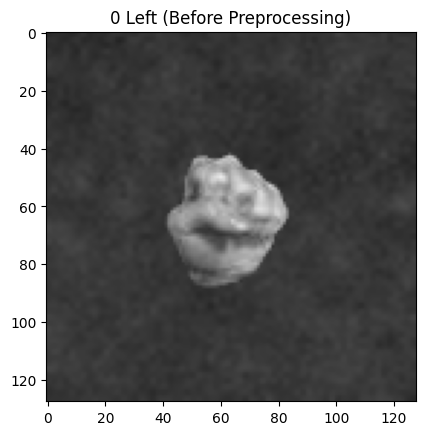

In [ ]:
BeforeImage = image.imread(new_path+"/test/0L/00ab429e-7edd-4cf7-b6a6-25eec65d5cda_0L.png")
plt.figure()
plt.title("0 Left (Before Preprocessing)")
plt.imshow(BeforeImage)

### **Preprocessed Images**

Train Datset Size Before Split 18000
Test Datset Size Before Split 2400
################################################
Train Datset Size After Split 18000
Test Datset Size After Split 2400
Validation Datset Size After Split 1200





################################################



Dataset After Pre-Processing


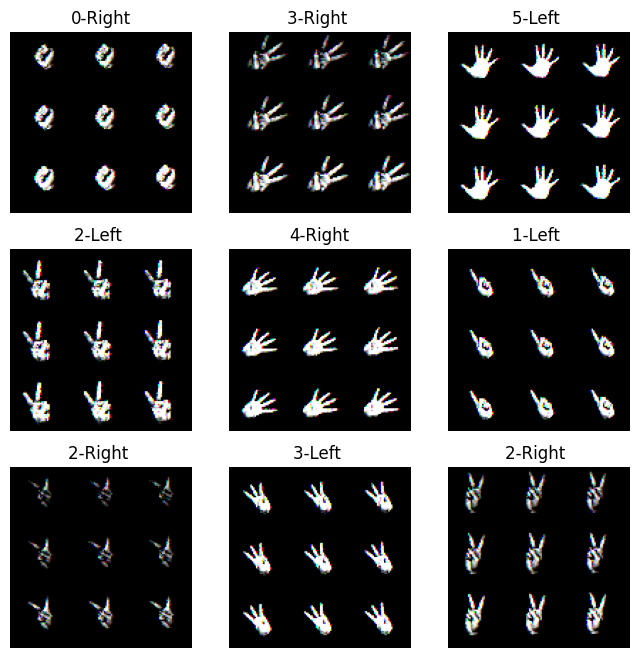

In [ ]:
def Display(data_dir_input,batch_sizeGiven,input_size,test_split,val_split,flag=1):
  data_loader(data_dir_input,batch_sizeGiven,input_size,test_split,val_split,1)
Display("/content/Assignment3",32, (128, 128) ,0.2, 0.1,1 )

### **Training Function**

In [ ]:
def train(num_epochsGiven, model, train_loader, criterion, optimizer,val_loader):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print("Device: {}".format(device))
  model.to(device)
  Accuracy=[]
  validAccuracy=[]
  Loss = []
  num_epochs = num_epochsGiven
  total_steps = len(train_loader)
  t1 = time.time()
  total,correct,loss=0,0,0
  for epoch in range(num_epochs):
      stepAcc=[]
      stepLoss=[]    
      for i, data in enumerate(train_loader):
          images, labels = data[0].to(device), data[1].to(device)
          # Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)
          # Backprop and optimisation
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          # Train accuracy
          total = labels.size(0)
          _,predicted = torch.max(outputs.data, 1)
          correct = (predicted == labels).sum().item()
          stepAcc.append((correct / total) * 100)
          stepLoss.append(loss.item())
          if (i + 1) % 100 == 0:
              print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(),
                     (correct / total) * 100))
      correct_v = 0
      total_v = 0
      for dataVal in val_loader:
          images_v, labels_v = dataVal[0].to(device), dataVal[1].to(device)
          outputs = model(images_v)
          _, predicted = torch.max(outputs.data, 1)
          correct_v += (predicted == labels_v).sum().item()
          total_v += labels_v.size(0)        
      Accuracy.append(sum(stepAcc)/len(stepAcc))
      validAccuracy.append((correct_v / total_v) * 100)
      Loss.append(sum(stepLoss)/len(stepLoss))
  print("######## Training Finished in {} seconds ###########".format(time.time()-t1))
  return Loss,Accuracy,model,validAccuracy

### **Testing of Model using different metrics**

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
def test(model, device, test_loader):
  model.eval() 
  y_truth=[]
  y_predicted=[]
  cm=[]
  with torch.no_grad(): 
      correct = 0
      total = 0
      for data in test_loader:
          images, labels = data[0].to(device), data[1].to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          #print(predicted,labels)
          correct += (predicted == labels).sum().item()
          y_truth+=labels.cpu().numpy().tolist()
          y_predicted+=predicted.cpu().numpy().tolist()
      print('Test Accuracy of the model on the {} test images: {} %'.format(total, (correct / total) * 100))
      cm= confusion_matrix(y_truth,y_predicted)
  print(classification_report(y_truth,y_predicted))
  return cm


### **Model 3(ResNet18)(Scratch)**

Learning Rate: 0.001 Batch Size: 32  Loss function:  Cross Entropy Loss  Optimizer:  Adam
Device: cuda
Epoch [1/5], Step [100/563], Loss: 0.3190, Accuracy: 87.50%
Epoch [1/5], Step [200/563], Loss: 0.3331, Accuracy: 90.62%
Epoch [1/5], Step [300/563], Loss: 0.2416, Accuracy: 96.88%
Epoch [1/5], Step [400/563], Loss: 0.0493, Accuracy: 100.00%
Epoch [1/5], Step [500/563], Loss: 0.0185, Accuracy: 100.00%
Epoch [2/5], Step [100/563], Loss: 0.0171, Accuracy: 100.00%
Epoch [2/5], Step [200/563], Loss: 0.0494, Accuracy: 96.88%
Epoch [2/5], Step [300/563], Loss: 0.0620, Accuracy: 96.88%
Epoch [2/5], Step [400/563], Loss: 0.1728, Accuracy: 93.75%
Epoch [2/5], Step [500/563], Loss: 0.0094, Accuracy: 100.00%
Epoch [3/5], Step [100/563], Loss: 0.0818, Accuracy: 96.88%
Epoch [3/5], Step [200/563], Loss: 0.0118, Accuracy: 100.00%
Epoch [3/5], Step [300/563], Loss: 0.0275, Accuracy: 100.00%
Epoch [3/5], Step [400/563], Loss: 0.0041, Accuracy: 100.00%
Epoch [3/5], Step [500/563], Loss: 0.0116, Accurac

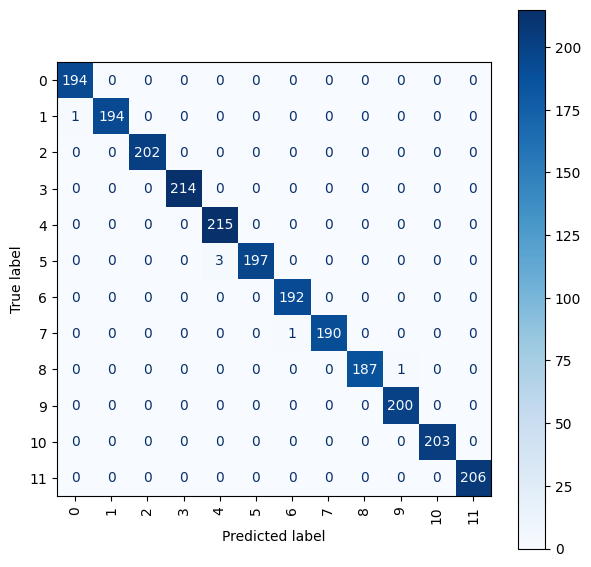

Learning Rate: 0.001 Batch Size: 32  Loss function:  Cross Entropy Loss  Optimizer:  SDG
Device: cuda
Epoch [1/5], Step [100/563], Loss: 2.3385, Accuracy: 12.50%
Epoch [1/5], Step [200/563], Loss: 1.7013, Accuracy: 34.38%
Epoch [1/5], Step [300/563], Loss: 1.1569, Accuracy: 59.38%
Epoch [1/5], Step [400/563], Loss: 0.8508, Accuracy: 81.25%
Epoch [1/5], Step [500/563], Loss: 0.5335, Accuracy: 93.75%
Epoch [2/5], Step [100/563], Loss: 0.4752, Accuracy: 90.62%
Epoch [2/5], Step [200/563], Loss: 0.2960, Accuracy: 93.75%
Epoch [2/5], Step [300/563], Loss: 0.3004, Accuracy: 93.75%
Epoch [2/5], Step [400/563], Loss: 0.2821, Accuracy: 96.88%
Epoch [2/5], Step [500/563], Loss: 0.2882, Accuracy: 90.62%
Epoch [3/5], Step [100/563], Loss: 0.2746, Accuracy: 90.62%
Epoch [3/5], Step [200/563], Loss: 0.0980, Accuracy: 100.00%
Epoch [3/5], Step [300/563], Loss: 0.1340, Accuracy: 93.75%
Epoch [3/5], Step [400/563], Loss: 0.0896, Accuracy: 100.00%
Epoch [3/5], Step [500/563], Loss: 0.0840, Accuracy: 96.

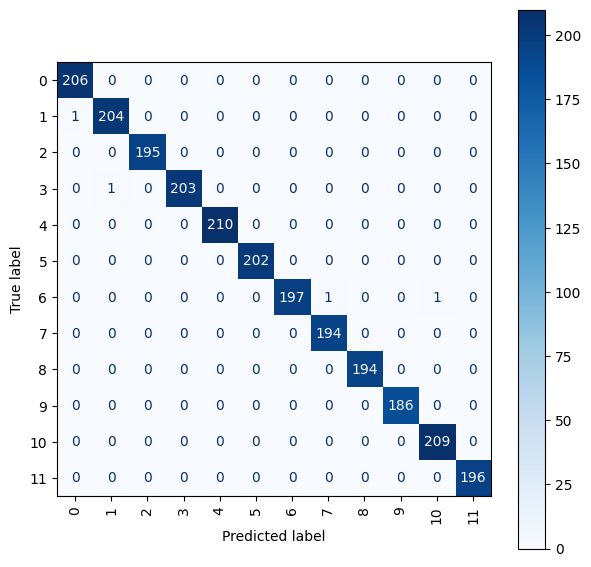

Learning Rate: 0.001 Batch Size: 64  Loss function:  Cross Entropy Loss  Optimizer:  Adam
Device: cuda
Epoch [1/5], Step [100/282], Loss: 0.6060, Accuracy: 70.31%
Epoch [1/5], Step [200/282], Loss: 0.0679, Accuracy: 100.00%
Epoch [2/5], Step [100/282], Loss: 0.0091, Accuracy: 100.00%
Epoch [2/5], Step [200/282], Loss: 0.0102, Accuracy: 100.00%
Epoch [3/5], Step [100/282], Loss: 0.0221, Accuracy: 98.44%
Epoch [3/5], Step [200/282], Loss: 0.0034, Accuracy: 100.00%
Epoch [4/5], Step [100/282], Loss: 0.0428, Accuracy: 96.88%
Epoch [4/5], Step [200/282], Loss: 0.0017, Accuracy: 100.00%
Epoch [5/5], Step [100/282], Loss: 0.0150, Accuracy: 100.00%
Epoch [5/5], Step [200/282], Loss: 0.0011, Accuracy: 100.00%
######## Training Finished in 832.7124860286713 seconds ###########
Test Accuracy of the model on the 2400 test images: 99.79166666666667 %
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       197
           1       1.00      0.99      1.

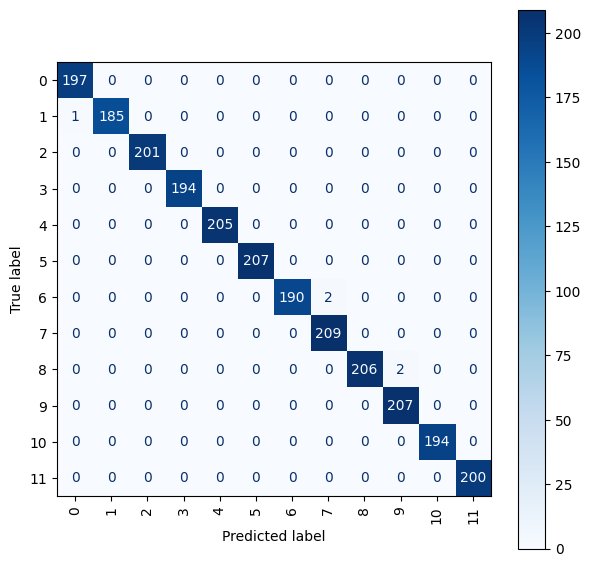

Learning Rate: 0.001 Batch Size: 64  Loss function:  Cross Entropy Loss  Optimizer:  SDG
Device: cuda
Epoch [1/5], Step [100/282], Loss: 2.1656, Accuracy: 25.00%
Epoch [1/5], Step [200/282], Loss: 1.6143, Accuracy: 48.44%
Epoch [2/5], Step [100/282], Loss: 0.7039, Accuracy: 82.81%
Epoch [2/5], Step [200/282], Loss: 0.4870, Accuracy: 87.50%
Epoch [3/5], Step [100/282], Loss: 0.3201, Accuracy: 93.75%
Epoch [3/5], Step [200/282], Loss: 0.1948, Accuracy: 98.44%
Epoch [4/5], Step [100/282], Loss: 0.1444, Accuracy: 96.88%
Epoch [4/5], Step [200/282], Loss: 0.2044, Accuracy: 98.44%
Epoch [5/5], Step [100/282], Loss: 0.0883, Accuracy: 100.00%
Epoch [5/5], Step [200/282], Loss: 0.0981, Accuracy: 98.44%
######## Training Finished in 829.0231964588165 seconds ###########
Test Accuracy of the model on the 2400 test images: 99.45833333333334 %
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       200
           1       0.99      0.99      0.99     

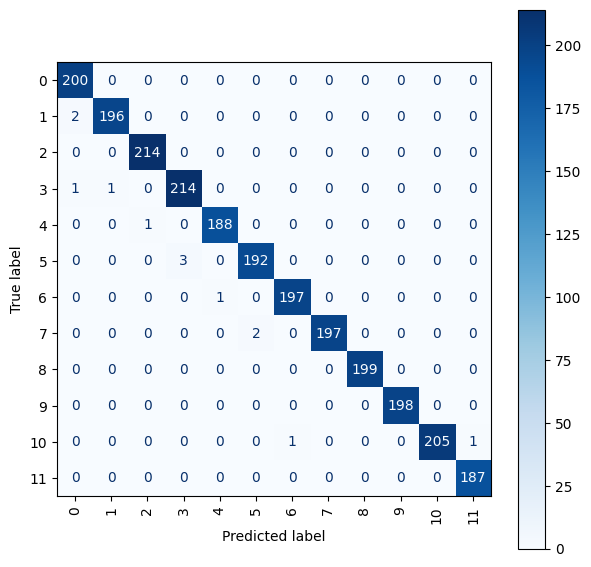

Learning Rate: 0.0001 Batch Size: 32  Loss function:  Cross Entropy Loss  Optimizer:  Adam
Device: cuda
Epoch [1/5], Step [100/563], Loss: 0.6056, Accuracy: 81.25%
Epoch [1/5], Step [200/563], Loss: 0.3145, Accuracy: 90.62%
Epoch [1/5], Step [300/563], Loss: 0.1380, Accuracy: 96.88%
Epoch [1/5], Step [400/563], Loss: 0.0963, Accuracy: 96.88%
Epoch [1/5], Step [500/563], Loss: 0.0209, Accuracy: 100.00%
Epoch [2/5], Step [100/563], Loss: 0.1481, Accuracy: 96.88%
Epoch [2/5], Step [200/563], Loss: 0.0422, Accuracy: 96.88%
Epoch [2/5], Step [300/563], Loss: 0.0122, Accuracy: 100.00%
Epoch [2/5], Step [400/563], Loss: 0.0441, Accuracy: 100.00%
Epoch [2/5], Step [500/563], Loss: 0.0308, Accuracy: 100.00%
Epoch [3/5], Step [100/563], Loss: 0.0709, Accuracy: 96.88%
Epoch [3/5], Step [200/563], Loss: 0.0177, Accuracy: 100.00%
Epoch [3/5], Step [300/563], Loss: 0.0148, Accuracy: 100.00%
Epoch [3/5], Step [400/563], Loss: 0.0119, Accuracy: 100.00%
Epoch [3/5], Step [500/563], Loss: 0.0100, Accura

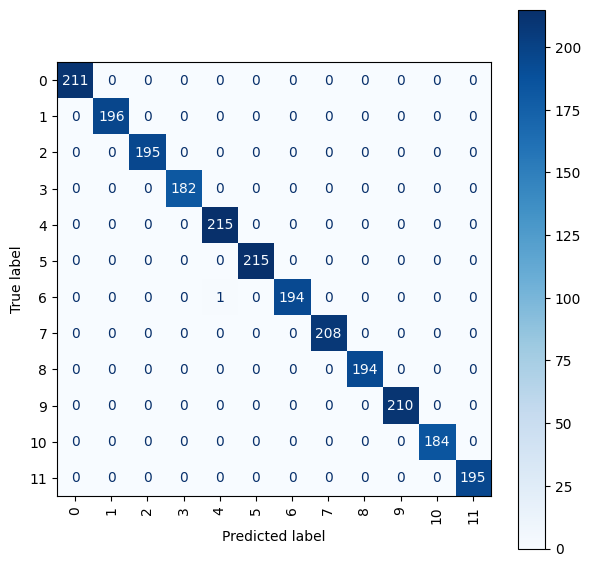

Learning Rate: 0.0001 Batch Size: 32  Loss function:  Cross Entropy Loss  Optimizer:  SDG
Device: cuda
Epoch [1/5], Step [100/563], Loss: 2.4645, Accuracy: 6.25%
Epoch [1/5], Step [200/563], Loss: 2.3384, Accuracy: 9.38%
Epoch [1/5], Step [300/563], Loss: 2.4177, Accuracy: 6.25%
Epoch [1/5], Step [400/563], Loss: 2.3400, Accuracy: 21.88%
Epoch [1/5], Step [500/563], Loss: 2.2358, Accuracy: 15.62%
Epoch [2/5], Step [100/563], Loss: 2.1706, Accuracy: 18.75%
Epoch [2/5], Step [200/563], Loss: 1.9842, Accuracy: 31.25%
Epoch [2/5], Step [300/563], Loss: 1.9817, Accuracy: 34.38%
Epoch [2/5], Step [400/563], Loss: 1.8670, Accuracy: 40.62%
Epoch [2/5], Step [500/563], Loss: 1.7719, Accuracy: 34.38%
Epoch [3/5], Step [100/563], Loss: 1.7925, Accuracy: 53.12%
Epoch [3/5], Step [200/563], Loss: 1.7021, Accuracy: 59.38%
Epoch [3/5], Step [300/563], Loss: 1.5399, Accuracy: 65.62%
Epoch [3/5], Step [400/563], Loss: 1.6054, Accuracy: 46.88%
Epoch [3/5], Step [500/563], Loss: 1.5992, Accuracy: 59.38%


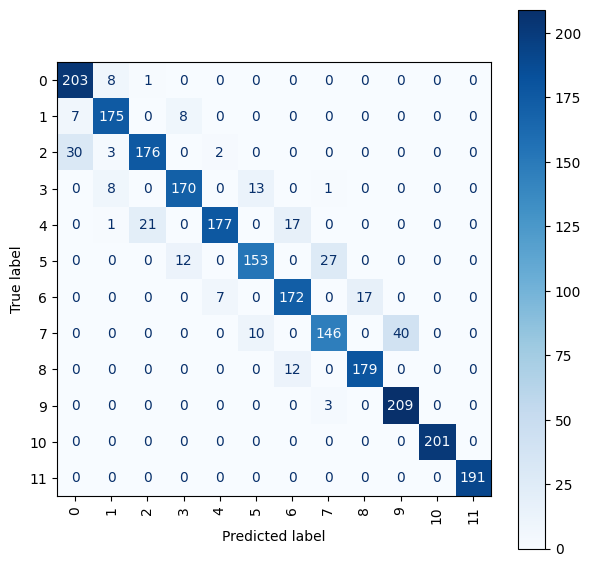

Learning Rate: 0.0001 Batch Size: 64  Loss function:  Cross Entropy Loss  Optimizer:  Adam
Device: cuda
Epoch [1/5], Step [100/282], Loss: 0.4290, Accuracy: 84.38%
Epoch [1/5], Step [200/282], Loss: 0.0594, Accuracy: 100.00%
Epoch [2/5], Step [100/282], Loss: 0.0553, Accuracy: 98.44%
Epoch [2/5], Step [200/282], Loss: 0.0833, Accuracy: 98.44%
Epoch [3/5], Step [100/282], Loss: 0.0319, Accuracy: 100.00%
Epoch [3/5], Step [200/282], Loss: 0.0064, Accuracy: 100.00%
Epoch [4/5], Step [100/282], Loss: 0.0249, Accuracy: 100.00%
Epoch [4/5], Step [200/282], Loss: 0.0046, Accuracy: 100.00%
Epoch [5/5], Step [100/282], Loss: 0.0096, Accuracy: 100.00%
Epoch [5/5], Step [200/282], Loss: 0.0145, Accuracy: 100.00%
######## Training Finished in 839.209463596344 seconds ###########
Test Accuracy of the model on the 2400 test images: 99.95833333333334 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       221
           1       1.00      0.99      1.

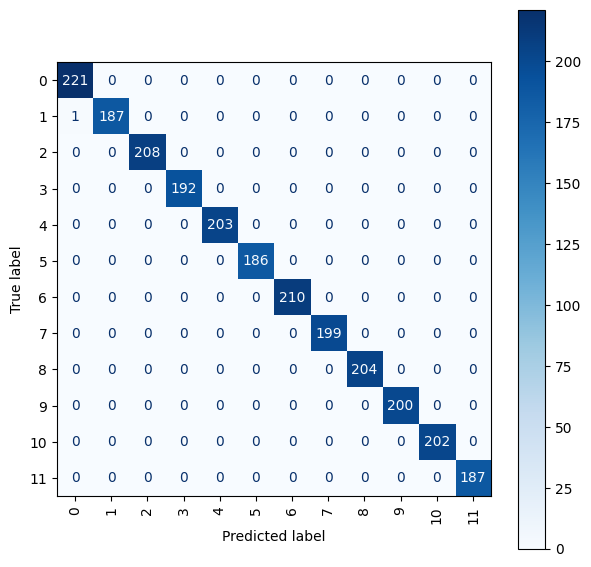

Learning Rate: 0.0001 Batch Size: 64  Loss function:  Cross Entropy Loss  Optimizer:  SDG
Device: cuda
Epoch [1/5], Step [100/282], Loss: 2.4301, Accuracy: 4.69%
Epoch [1/5], Step [200/282], Loss: 2.3397, Accuracy: 9.38%
Epoch [2/5], Step [100/282], Loss: 2.2430, Accuracy: 25.00%
Epoch [2/5], Step [200/282], Loss: 2.2100, Accuracy: 21.88%
Epoch [3/5], Step [100/282], Loss: 2.0938, Accuracy: 23.44%
Epoch [3/5], Step [200/282], Loss: 2.1096, Accuracy: 34.38%
Epoch [4/5], Step [100/282], Loss: 1.7998, Accuracy: 54.69%
Epoch [4/5], Step [200/282], Loss: 1.7691, Accuracy: 45.31%
Epoch [5/5], Step [100/282], Loss: 1.7135, Accuracy: 56.25%
Epoch [5/5], Step [200/282], Loss: 1.5994, Accuracy: 57.81%
######## Training Finished in 826.9657545089722 seconds ###########
Test Accuracy of the model on the 2400 test images: 56.375 %
              precision    recall  f1-score   support

           0       0.27      0.04      0.07       191
           1       0.34      1.00      0.51       201
       

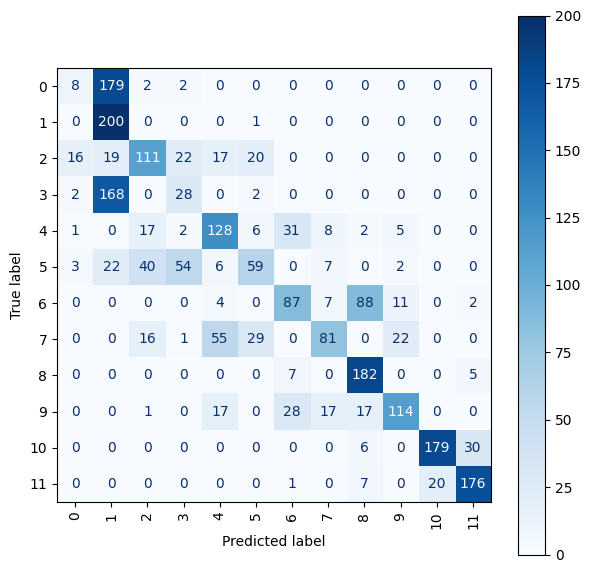

In [ ]:
MODELS3=[]
hyper_parameters3 = []
train_acc_hyper_paramaters3=[]
train_acc_valid_hyper_paramaters3=[]
train_loss_hyper_paramaters3=[]

stringCrit="Cross Entropy Loss"
criterion=nn.CrossEntropyLoss()
batch_sizes=[32,64]
learning_rates=[0.001,.0001]
epochs=5


for learning_rate in learning_rates:
  for batch_size in batch_sizes:
    for optimizer_count in range(2):
      model3 = models.resnet18(weights=None,progress=False)
      model3.fc = nn.Linear(512, 12)
      stringOPTM=""
      if optimizer_count%2==0:
       stringOPTM="Adam" 
       optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate)
      else:
        stringOPTM="SDG"
        optimizer = torch.optim.SGD(model3.parameters(), lr=learning_rate, momentum=0.9)
      hyper_parameters3.append(["Learning Rate: "+str(learning_rate)+" Batch Size: "+str(batch_size),stringCrit,stringOPTM])
      print("Learning Rate: "+str(learning_rate)+" Batch Size: "+str(batch_size)," Loss function: ",stringCrit," Optimizer: ",stringOPTM)
      #optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
      train_loader, test_loader, val_loader = data_loader("/content/Assignment3",batch_size, (224, 224) ,0.2, 0.1 )
      tempLoss,tempAccuracy,tempModel,tempValidAccuracy = train(epochs,model3,train_loader,criterion,optimizer,val_loader)
      train_loss_hyper_paramaters3.append(tempLoss)
      train_acc_hyper_paramaters3.append(tempAccuracy)
      train_acc_valid_hyper_paramaters3.append(tempValidAccuracy)
      cmReturned = test(model3,"cuda",test_loader)
      if cmReturned is not None:
          fig, ax = plt.subplots(figsize=(7, 7))
          ConfusionMatrixDisplay(cmReturned).plot(ax=ax,cmap='Blues', xticks_rotation='vertical', values_format='d')
          plt.show()
      MODELS3.append(tempModel)
  

### **Accuracy Plot**

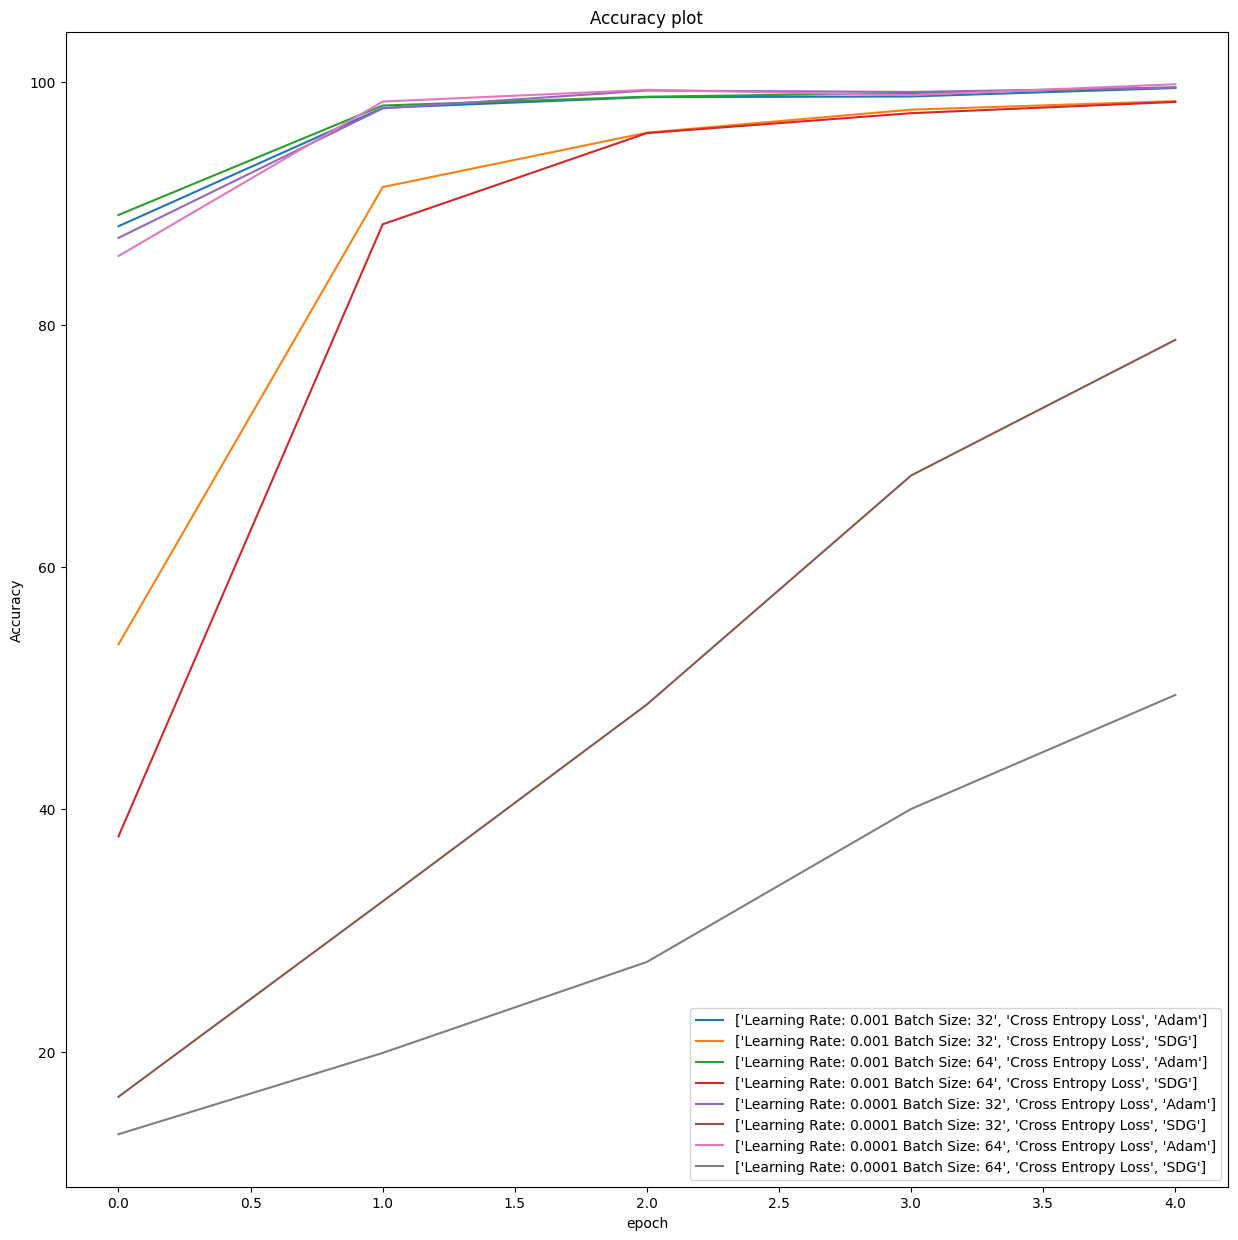

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from numpy.core.multiarray import dtype
####### plot the the training accuracy here #########
num_epochs=5
epochs = [i for i in range(num_epochs)]
plt.figure(figsize=(15, 15))
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')

#train_loss_hyper_paramaters.numpy()
#print(train_loss_hyper_paramaters["lr0.01"])

for i in range(len(hyper_parameters3)):
    plt.plot(train_acc_hyper_paramaters3[i],label=hyper_parameters3[i])
plt.legend()

### **Loss Plot**

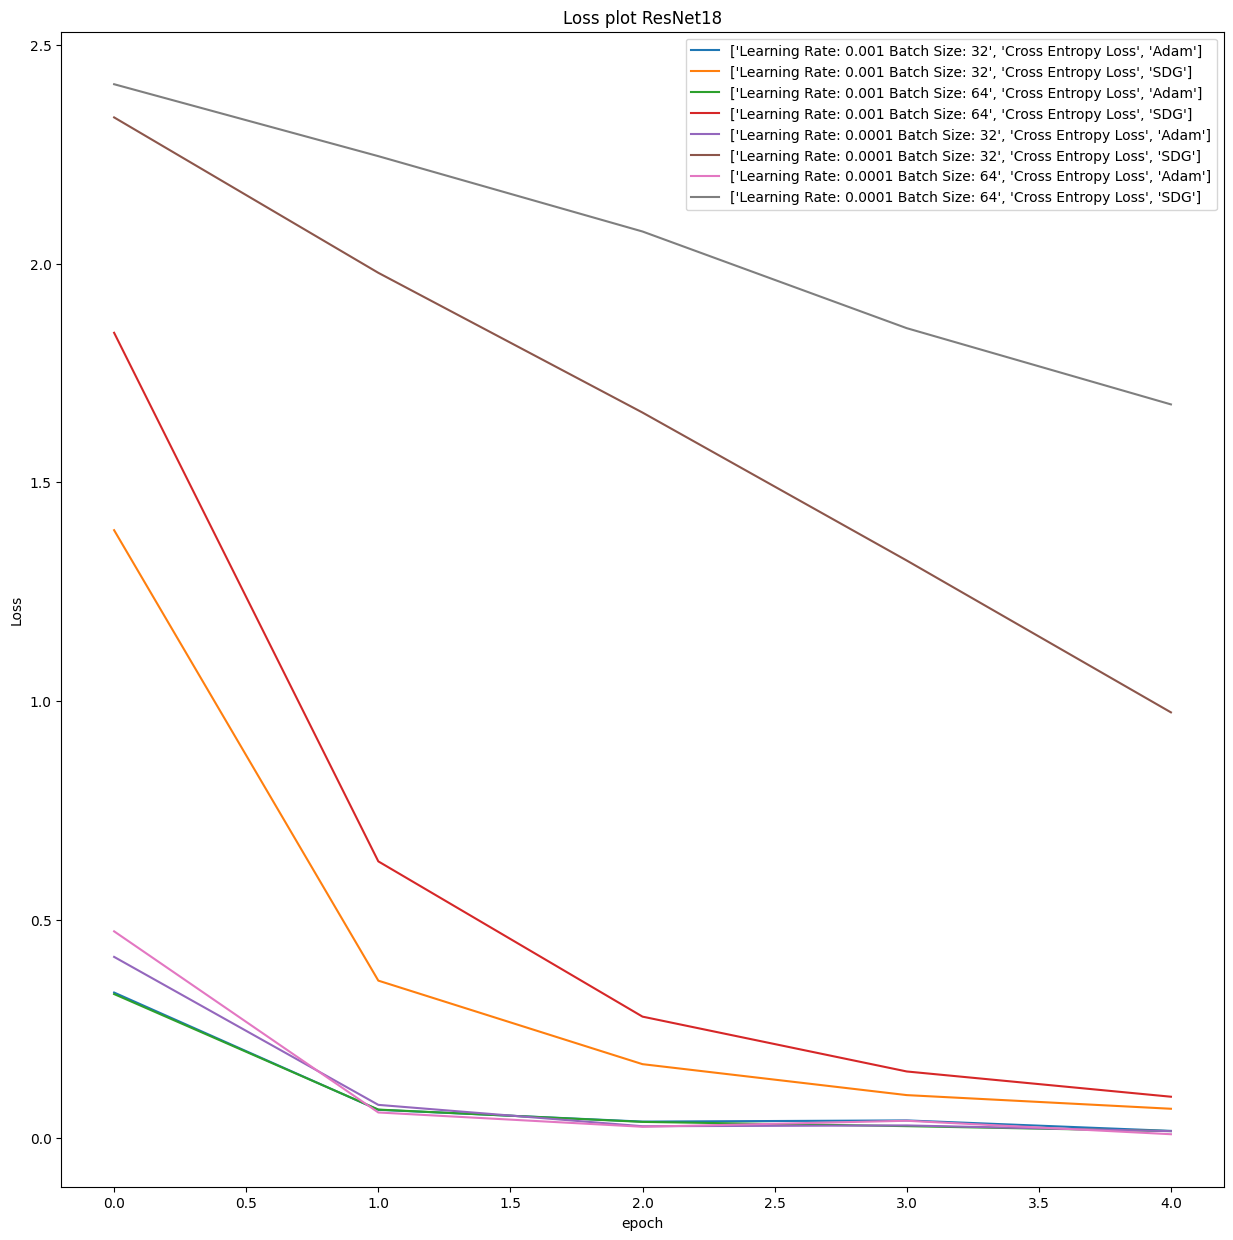

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from numpy.core.multiarray import dtype
####### plot the the training loss here #########
num_epochs=5
epochs = [i for i in range(num_epochs)]
plt.figure(figsize=(15, 15))
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot ResNet18')

#train_loss_hyper_paramaters.numpy()
#print(train_loss_hyper_paramaters["lr0.01"])

for i in range(len(hyper_parameters3)):
    plt.plot(train_loss_hyper_paramaters3[i],label=hyper_parameters3[i])
plt.legend()

### **Validation Accuracy**

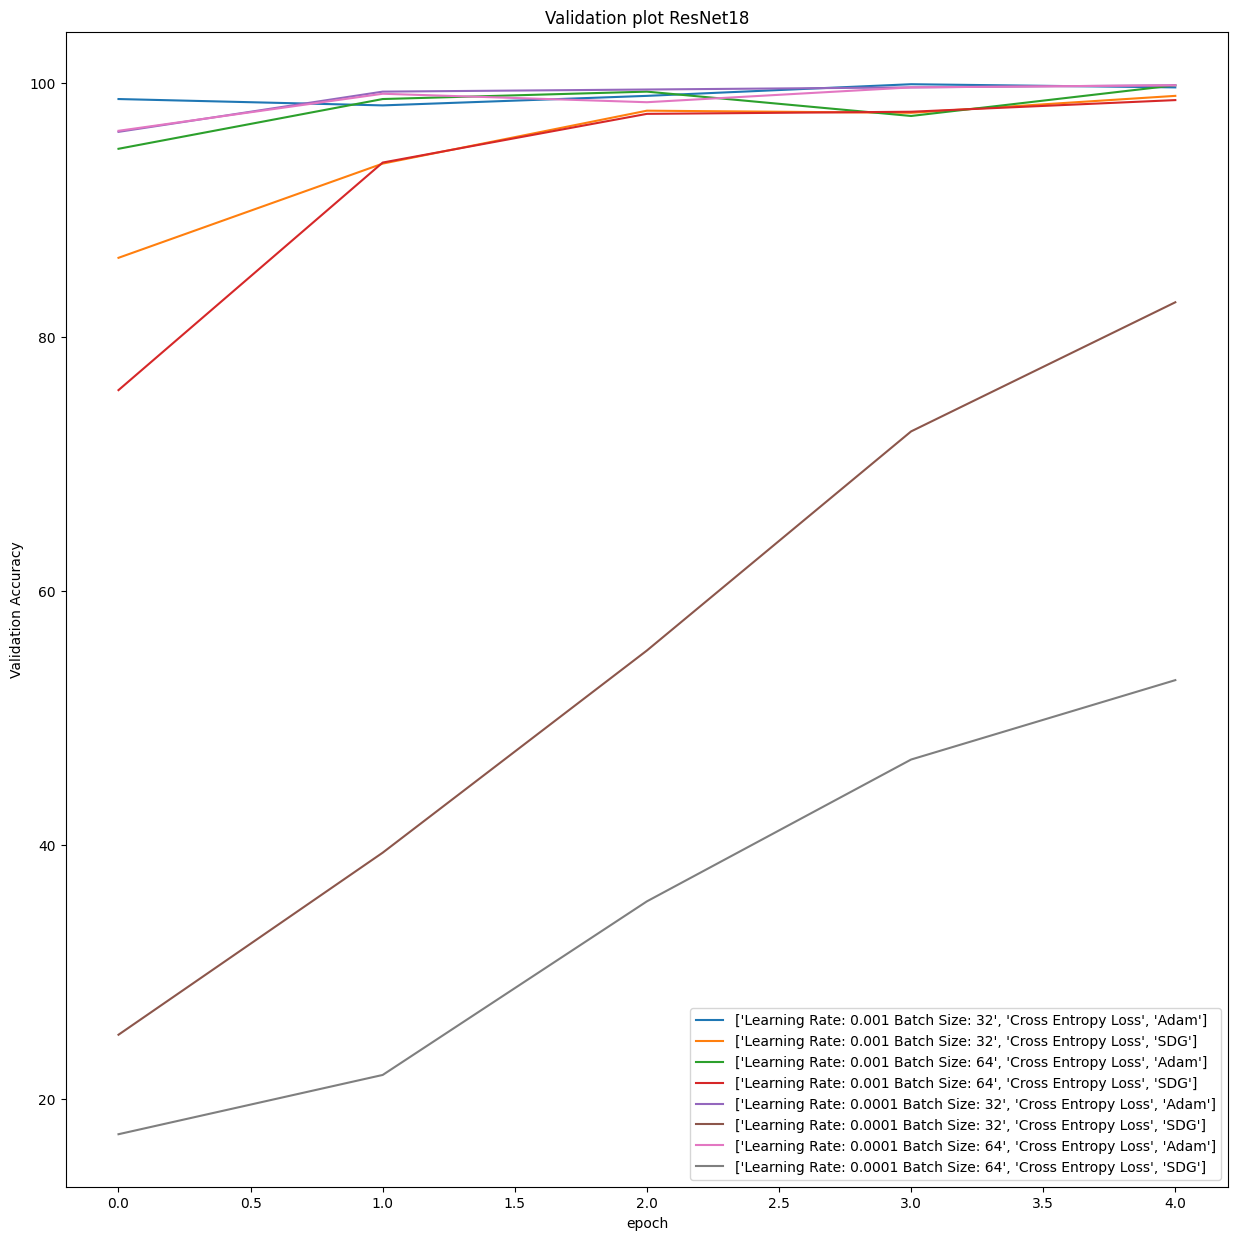

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from numpy.core.multiarray import dtype
####### plot the the training loss here #########
num_epochs=5
epochs = [i for i in range(num_epochs)]
plt.figure(figsize=(15, 15))
plt.xlabel('epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation plot ResNet18')

#train_loss_hyper_paramaters.numpy()
#print(train_loss_hyper_paramaters["lr0.01"])

for i in range(len(hyper_parameters3)):
    plt.plot(train_acc_valid_hyper_paramaters3[i],label=hyper_parameters3[i])
plt.legend()

### **Saving the Model**

In [ ]:
i=0
for modelsResnet in MODELS3:
   torch.save(tempModel,'/content/drive/MyDrive/Models ResNet/'+"_".join(hyper_parameters3[i])+".pth")
   torch.save(tempModel,'/content/drive/MyDrive/Models ResNet/'+"_".join(hyper_parameters3[i])+".pt")
   i=i+1

### **Input image to the trained models**

In [ ]:
TempTransformer = transforms.Compose([
      transforms.Resize((128,128), interpolation=transforms.InterpolationMode.BILINEAR),
      transforms.RandomRotation(50),
      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
      transforms.RandomPerspective(distortion_scale=0.2, p=0.2),
      transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
      transforms.ToTensor(),           
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])


from PIL import Image
imageInput = Image.open(new_path+"/train/5L/009850f5-6bf5-445d-88dd-25f6ccbe538b_5L.png")
input_data = TempTransformer(imageInput)
input_data = input_data.to(device)
input_data = input_data.unsqueeze(0)
i=0
for tempModelList in MODELS3:
  tempModelList.eval()
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  tempModelList.to(device)
  print(" ".join(hyper_parameters3[i]))
  with torch.no_grad():
    output = tempModelList(input_data)

  out=output.tolist()[0]
  print(labels_map[out.index(max(out))])
  i=i+1

Learning Rate: 0.001 Batch Size: 32 Cross Entropy Loss Adam
4-Left 
Learning Rate: 0.001 Batch Size: 32 Cross Entropy Loss SDG
5-Left 
Learning Rate: 0.001 Batch Size: 64 Cross Entropy Loss Adam
5-Left 
Learning Rate: 0.001 Batch Size: 64 Cross Entropy Loss SDG
5-Left 
Learning Rate: 0.0001 Batch Size: 32 Cross Entropy Loss Adam
5-Left 
Learning Rate: 0.0001 Batch Size: 32 Cross Entropy Loss SDG
4-Left 
Learning Rate: 0.0001 Batch Size: 64 Cross Entropy Loss Adam
5-Left 
Learning Rate: 0.0001 Batch Size: 64 Cross Entropy Loss SDG
4-Left 
